# MLP

In [1]:
import numpy as np
import pandas as pd

import random
random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt

import torch
torch.random.seed = 42
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
!cat ../data/wines_classification/winequality.names

In [3]:
!head ../data/wines_classification/winequality-red.csv

"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5
11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58;9.8;6
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.4;0.66;0;1.8;0.075;13;40;0.9978;3.51;0.56;9.4;5
7.9;0.6;0.06;1.6;0.069;15;59;0.9964;3.3;0.46;9.4;5
7.3;0.65;0;1.2;0.065;15;21;0.9946;3.39;0.47;10;7
7.8;0.58;0.02;2;0.073;9;18;0.9968;3.36;0.57;9.5;7


In [4]:
df1 = pd.read_csv("../data/wines_classification/winequality-red.csv", sep=";") # skip feature names
df2 = pd.read_csv("../data/wines_classification/winequality-white.csv", sep=";")
df = pd.concat([df1, df2])

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
data = torch.tensor(df.sample(frac=1).values, dtype=torch.float)
data

tensor([[ 6.1000,  0.4400,  0.2800,  ...,  0.4700, 11.3000,  7.0000],
        [ 8.4000,  0.6500,  0.6000,  ...,  0.5200,  9.2000,  5.0000],
        [ 7.6000,  0.1900,  0.3800,  ...,  0.3800, 10.5000,  6.0000],
        ...,
        [ 7.2000,  0.6700,  0.0000,  ...,  0.7200, 11.1000,  6.0000],
        [ 6.4000,  0.1500,  0.4400,  ...,  0.7300, 11.2000,  7.0000],
        [ 6.8000,  0.3600,  0.3200,  ...,  0.6700,  9.6000,  5.0000]])

In [6]:
mu = np.mean(data.numpy(), 0)
std = (np.max(data.numpy(), 0) - np.min(data.numpy(), 0))

data_norm = torch.zeros_like(data)

for i, l in enumerate(data):
    for j, e in enumerate(l):
        data_norm[i, j] = (e - mu[j])/std[j]

In [7]:
X = data_norm[:,0:11]
y = data_norm[:, 11]

In [8]:
X_train = X[:4548, :]
y_train = y[:4548]

X_test = X[4548:, :]
y_test = y[4548:]

In [9]:
M, N = X_train.size()
print(M, N)

4548 11


In [10]:
class Net(nn.Module):
    
    def __init__(self, N, O):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N, O)
        self.fc2 = nn.Linear(O, 1)
        self.th = nn.Tanh()
        
    def forward(self, x):
        x = self.th(self.fc1(x))
        x = self.fc2(x)
        return x
    
net = Net(N, 20)
print(net)

Net(
  (fc1): Linear(in_features=11, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
  (th): Tanh()
)


In [11]:
list(net.parameters())

[Parameter containing:
 tensor([[-0.0967,  0.1772, -0.2342, -0.1966,  0.0756, -0.1077, -0.0910, -0.2097,
          -0.1026, -0.1016,  0.2016],
         [ 0.2085, -0.0618,  0.2390,  0.0720, -0.2006, -0.0401, -0.0633,  0.2592,
           0.0747, -0.1375,  0.2913],
         [ 0.1738, -0.0207, -0.1488,  0.1208, -0.1926,  0.2479, -0.0931,  0.0257,
           0.0478,  0.0758,  0.2877],
         [-0.2656, -0.0471,  0.0709,  0.0971, -0.0230,  0.1764, -0.2440, -0.0156,
          -0.2228,  0.1482, -0.1236],
         [-0.1397, -0.0470,  0.2136,  0.2190,  0.2727,  0.1915,  0.0592,  0.0620,
           0.1914,  0.1708, -0.2346],
         [-0.0042, -0.2392,  0.1833, -0.0831, -0.1851,  0.0124,  0.0797,  0.0739,
          -0.0465, -0.2411,  0.1709],
         [-0.1795, -0.0308, -0.0476, -0.0672,  0.2728,  0.1340,  0.2238, -0.1991,
           0.2705, -0.1188, -0.0926],
         [ 0.0853, -0.0149,  0.0004, -0.2899,  0.0373,  0.2555, -0.2882, -0.2170,
          -0.2096, -0.0888, -0.0738],
         [ 0.1752

In [12]:
criterion = nn.MSELoss(reduction='mean')

In [13]:
def batch_train_step(net, X, y, alpha):
    net.zero_grad()
    output = net(X_train)
    loss = criterion(output, y_train)
    #loss = loss/N
    loss.backward()
    for f in net.parameters():
        f.data.sub_(f.grad.data * alpha)
    return loss.detach()

In [14]:
def batch_train(net, X, y, X_test, y_test, alpha=0.1, epsilon=0.001, gamma=100, max_iter=1000):
    mse_test_vec = []
    mse_train_vec = []
    mse_test = epsilon+1
    mse_min = 9999
    counter = 0
    iter = 0
    
    while (counter < gamma and mse_test > epsilon and iter < max_iter):
        output = net(X_test)
        mse_test = criterion(output, y_test).detach()
        mse_test_vec.append(mse_test)
        mse_train = batch_train_step(net, X, y, alpha)
        mse_train_vec.append(mse_train)

        
        if (mse_test >= mse_min):
            counter += 1
        else:
            mse_min = mse_test
            counter = 0
        
        iter += 1

    return (mse_train_vec, mse_test_vec)
        

In [15]:
epsilon = 0.01
alpha = 0.1
gamma = 50
max_iter = 1000

O: 10 alpha: 0.003
O:  10 alpha: 0.003
MSE_train: 0.021855867 MSE_test: 0.022529684


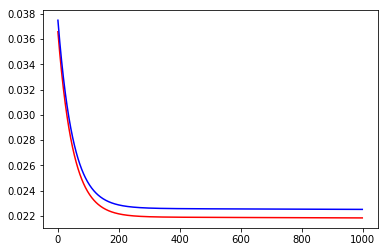

O: 10 alpha: 0.006
O:  10 alpha: 0.006
MSE_train: 0.02134974 MSE_test: 0.022031587


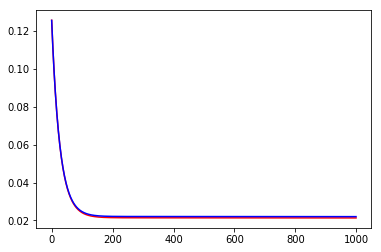

O: 10 alpha: 0.01
O:  10 alpha: 0.01
MSE_train: 0.021529512 MSE_test: 0.02218597


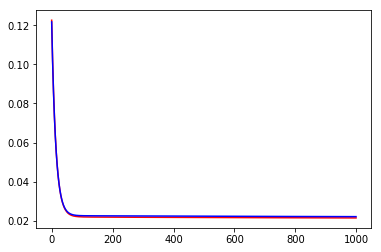

O: 10 alpha: 0.03
O:  10 alpha: 0.03
MSE_train: 0.021167295 MSE_test: 0.021854162


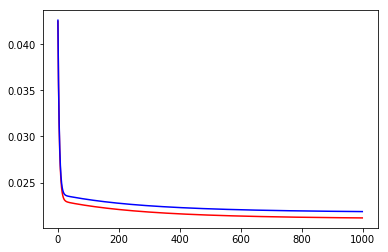

O: 10 alpha: 0.06
O:  10 alpha: 0.06
MSE_train: 0.021190725 MSE_test: 0.021854652


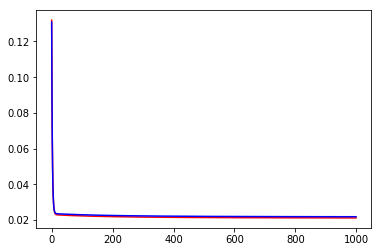

O: 30 alpha: 0.003
O:  30 alpha: 0.003
MSE_train: 0.02180614 MSE_test: 0.022458958


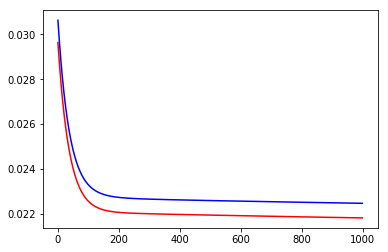

O: 30 alpha: 0.006
O:  30 alpha: 0.006
MSE_train: 0.021536076 MSE_test: 0.022224791


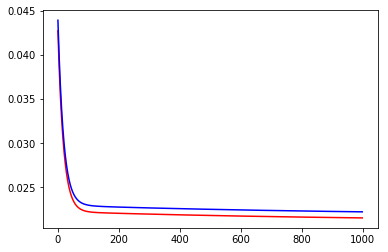

O: 30 alpha: 0.01
O:  30 alpha: 0.01
MSE_train: 0.021239515 MSE_test: 0.021908239


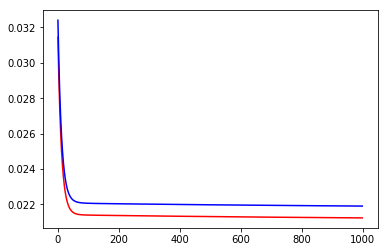

O: 30 alpha: 0.03
O:  30 alpha: 0.03
MSE_train: 0.021071648 MSE_test: 0.021758782


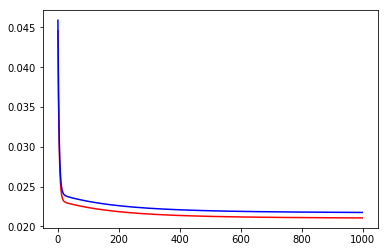

O: 30 alpha: 0.06
O:  30 alpha: 0.06
MSE_train: 0.021027876 MSE_test: 0.021708768


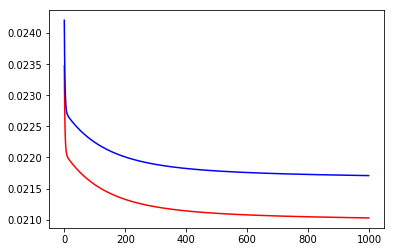

O: 80 alpha: 0.003
O:  80 alpha: 0.003
MSE_train: 0.021226902 MSE_test: 0.02191237


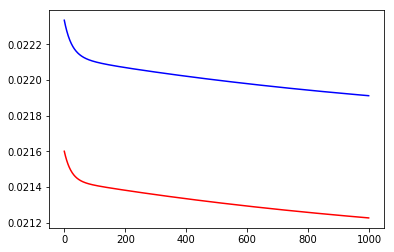

O: 80 alpha: 0.006
O:  80 alpha: 0.006
MSE_train: 0.021328805 MSE_test: 0.021990247


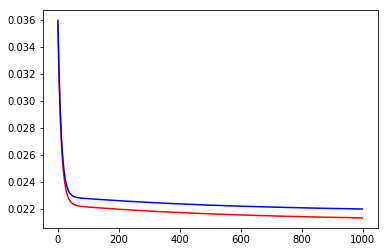

O: 80 alpha: 0.01
O:  80 alpha: 0.01
MSE_train: 0.021153536 MSE_test: 0.021847166


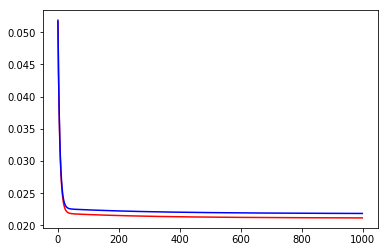

O: 80 alpha: 0.03
O:  80 alpha: 0.03
MSE_train: 0.021056289 MSE_test: 0.021733632


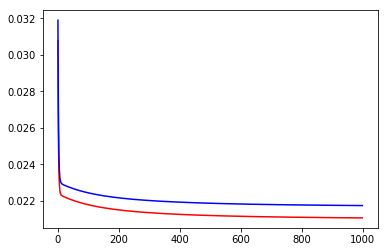

O: 80 alpha: 0.06
O:  80 alpha: 0.06
MSE_train: 0.021000525 MSE_test: 0.021681832


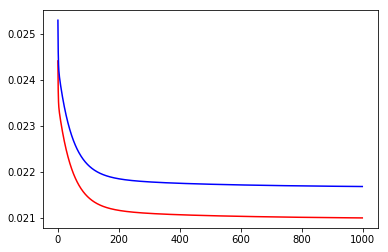

O: 150 alpha: 0.003
O:  150 alpha: 0.003
MSE_train: 0.021450821 MSE_test: 0.022168329


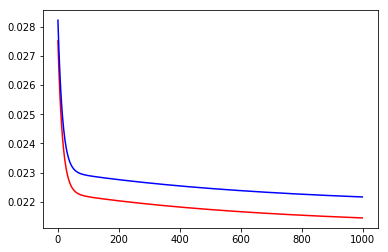

O: 150 alpha: 0.006
O:  150 alpha: 0.006
MSE_train: 0.021127444 MSE_test: 0.021809481


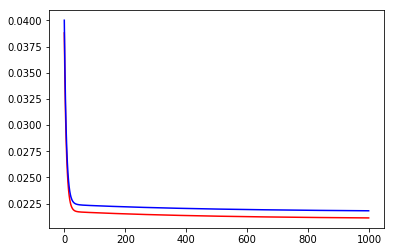

O: 150 alpha: 0.01
O:  150 alpha: 0.01
MSE_train: 0.021157956 MSE_test: 0.021850003


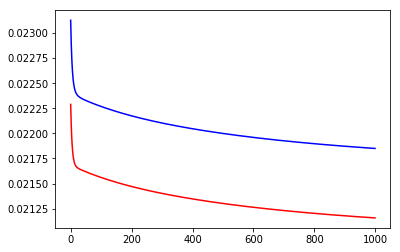

O: 150 alpha: 0.03
O:  150 alpha: 0.03
MSE_train: 0.020994361 MSE_test: 0.021680497


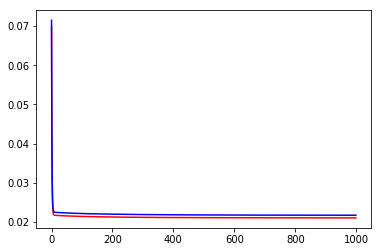

O: 150 alpha: 0.06
O:  150 alpha: 0.06
MSE_train: 0.020978263 MSE_test: 0.021659974


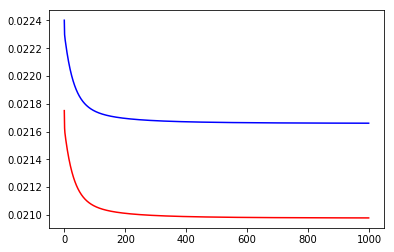

In [16]:
for O in [10, 30, 80, 150]:
    for alpha in [0.003, 0.006, 0.01, 0.03, 0.06]:
        print("O:", O, "alpha:", alpha)
        net = Net(N, O)
        
        (a, b) = batch_train(net, X_train, y_train, X_test, y_test,
                            alpha, epsilon, gamma, max_iter)
        
        print("O: ", O, "alpha:", alpha)
        print("MSE_train:", np.min(a), "MSE_test:", np.min(b))
        plt.plot(a, "r")
        plt.hold = True
        plt.plot(b, "b")
        plt.hold = False
        plt.show()